In [1]:
# Import necessary functions
import os
import sys
import logging
import time
import numpy as np
import glob
import yaml
from pprint import pprint  # For better printing of the config dictionary
from IPython.display import Video, display

# For interactive plots in .ipynb scripts
%matplotlib widget

from experiment_runner import run_experiment
from utils.trajectory_log_schema import TRAJECTORY_LOG_COLUMN_MAP 
from utils.plot_utils import animate_trajectory_from_log, plot_reward_per_episode_series, plot_result_ration

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    stream=sys.stdout,
    force=True 
)

In [ ]:
# Load configuration and run the experiment
#config_file_path = 'configs/config.yaml'

config_file_path = '/Users/ruzejjur/Github/ARAMARL_TMDP_DP/TMDP_DP/configs/config_new_trajec_save_test.yaml'


results_path = run_experiment(config_file_path, log_trajectory=True)

In [3]:
# Specify the Experiment Run to Analyze
# ---------------------------------------------
# TODO: The path can be set to the specific, timestamped experiment folder you want to analyze.

# --- Select moving average window size and range for the player reward plots
plot_reward_bands = True
plot_moving_average_window_size = 1000
reward_time_series_x_axis_plot_range = [0,19999]

plot_result_ratio_bands = True
episode_range_to_eval = [19899,19999] # Checking the win, loss and draw ratio dynamic for last 100 episodes
game_result_ratio_x_axis_plot_range = [19899,19999]


# --- Select which trajectory to animate ---
# The log is structured as: [experiment_run][episode][step]
run_to_animate = 9      # The last experiment run
episode_to_animate = 19999 # The last episode of that run

#results_run_directory = results_path

results_run_directory = '/Users/ruzejjur/Github/ARAMARL_TMDP_DP/TMDP_DP/results/MDP_DP_Agent_PerfectModel_vs_ManhattanAgent_Passive_2025-08-20_16-44-52'


In [4]:
# --- Load data ---

# Verify that the directory exists before proceeding
if not os.path.isdir(results_run_directory):
    raise FileNotFoundError(f"The specified directory does not exist: {results_run_directory}")

logging.info(f"Loading results from: {results_run_directory}")

# --- Load Configuration ---
config_path = os.path.join(results_run_directory, 'config*.yaml')
found_configs = glob.glob(config_path)

config = None
if not found_configs:

    logging.error(f"No configuration file matching 'config*.yaml' found in the directory: {results_run_directory}")
    raise FileNotFoundError("Could not find a configuration file to load.")
else:
    if len(found_configs) > 1:
        
        logging.warning(
            f"Multiple configuration files found: {found_configs}. "
            f"Loading the first one: '{os.path.basename(found_configs[0])}'."
        )
        
    config_path = found_configs[0]
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        logging.info(f"Configuration file '{os.path.basename(config_path)}' loaded successfully.")
        
        # Use pprint for a cleaner print of the configuration dictionary
        logging.info("\n--- Experiment Configuration ---")
        pprint(config)
        logging.info("--------------------------------")
    except Exception as e:
        logging.error(f"Failed to load or parse the configuration file at: {config_path}. Error: {e}")
        # Ensure config is None if loading fails
        config = None


# --- Load Reward Data ---

# Loading full rewards data
full_rewards_p0_path = os.path.join(results_run_directory, 'full_rewards_per_episode_p0.npz')
full_rewards_p1_path = os.path.join(results_run_directory, 'full_rewards_per_episode_p1.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(full_rewards_p0_path)
    data_p1 = np.load(full_rewards_p1_path)
    
    full_rewards_p0 = data_p0['full_rewards_p0']
    full_rewards_p1 = data_p1['full_rewards_p1']
    
    logging.info(f"\n Full reward data loaded successfully. Shape: {full_rewards_p0.shape}")
except FileNotFoundError:
    logging.error("Full reward data (.npz files) not found in the directory.")

    full_rewards_p0, full_rewards_p1 = None, None
    
# Loading positive rewards data
positive_rewards_p0_path = os.path.join(results_run_directory, 'positive_rewards_per_episode_p0.npz')
positive_rewards_p1_path = os.path.join(results_run_directory, 'positive_rewards_per_episode_p1.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(positive_rewards_p0_path)
    data_p1 = np.load(positive_rewards_p1_path)

    positive_rewards_p0 = data_p0['positive_rewards_p0']
    positive_rewards_p1 = data_p1['positive_rewards_p1']

    logging.info(f"\n Positive reward data loaded successfully. Shape: {positive_rewards_p0.shape}")
except FileNotFoundError:
    logging.error("Positive reward data (.npz files) not found in the directory.")

    positive_rewards_p0, positive_rewards_p1 = None, None
    
# Loading negative rewards data
negative_rewards_p0_path = os.path.join(results_run_directory, 'negative_rewards_per_episode_p0.npz')
negative_rewards_p1_path = os.path.join(results_run_directory, 'negative_rewards_per_episode_p1.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(negative_rewards_p0_path)
    data_p1 = np.load(negative_rewards_p1_path)
    
    negative_rewards_p0 = data_p0['negative_rewards_p0']
    negative_rewards_p1 = data_p1['negative_rewards_p1']
    
    logging.info(f"\n Negative reward data loaded successfully. Shape: {negative_rewards_p0.shape}")
except FileNotFoundError:
    logging.error("Negative reward data (.npz files) not found in the directory.")
    
    negative_rewards_p0, negative_rewards_p1 = None, None
    
# Loading only step rewards data
only_step_rewards_p0_path = os.path.join(results_run_directory, 'only_step_rewards_per_episode_p0.npz')
only_step_rewards_p1_path = os.path.join(results_run_directory, 'only_step_rewards_per_episode_p1.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(only_step_rewards_p0_path)
    data_p1 = np.load(only_step_rewards_p1_path)
    
    only_step_rewards_p0 = data_p0['only_step_rewards_p0']
    only_step_rewards_p1 = data_p1['only_step_rewards_p1']
    
    logging.info(f"\n Only step reward data loaded successfully. Shape: {only_step_rewards_p0.shape}")
except FileNotFoundError:
    logging.error("Only step reward data (.npz files) not found in the directory.")
    
    only_step_rewards_p0, only_step_rewards_p1 = None, None
    
# Loading full rewards without coin data
full_rewards_without_coin_p0_path = os.path.join(results_run_directory, 'full_rewards_without_coin_per_episode_p0.npz')
full_rewards_without_coin_p1_path = os.path.join(results_run_directory, 'full_rewards_without_coin_per_episode_p1.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(full_rewards_without_coin_p0_path)
    data_p1 = np.load(full_rewards_without_coin_p1_path)
    
    full_rewards_without_coin_p0 = data_p0['full_rewards_without_coin_p0']
    full_rewards_without_coin_p1 = data_p1['full_rewards_without_coin_p1']
    
    logging.info(f"\n Full reward without coin data loaded successfully. Shape: {full_rewards_without_coin_p0.shape}")
except FileNotFoundError:
    logging.error("Full reward without coin data (.npz files) not found in the directory.")

    full_rewards_without_coin_p0, full_rewards_without_coin_p1 = None, None
    
# Loading full rewards without step data
full_rewards_without_step_p0_path = os.path.join(results_run_directory, 'full_rewards_without_step_per_episode_p0.npz')
full_rewards_without_step_p1_path = os.path.join(results_run_directory, 'full_rewards_without_step_per_episode_p1.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(full_rewards_without_step_p0_path)
    data_p1 = np.load(full_rewards_without_step_p1_path)
    
    full_rewards_without_step_p0 = data_p0['full_rewards_without_step_p0']
    full_rewards_without_step_p1 = data_p1['full_rewards_without_step_p1']
    
    logging.info(f"\n Full reward without step data loaded successfully. Shape: {full_rewards_without_step_p0.shape}")
except FileNotFoundError:
    logging.error("Full reward without step data (.npz files) not found in the directory.")

    full_rewards_without_step_p0, full_rewards_without_step_p1 = None, None
    
# Loading game result for player 1
game_result_p0_path = os.path.join(results_run_directory, 'game_result_episode_p0.npz')
try:
    # Use np.load to read the saved NumPy array files
    data_p0 = np.load(game_result_p0_path)
    
    game_result_p0 = data_p0['game_result_p0']
    
    logging.info(f"\n Game result for player 1 data loaded successfully. Shape: {game_result_p0.shape}")
except FileNotFoundError:
    logging.error("Game result for player 1 data (.npz files) not found in the directory.")

    game_result_p0 = None
    
# --- Load Trajectory Data ---
# This will only exist if log_trajectory=True was used for the run.
trajectory_path = os.path.join(results_run_directory, 'trajectory_log.npz')
try:
    
    data = np.load(trajectory_path)
    trajectory_logs_all_experiments = data['trajectory_logs_all_experiments']
    
    logging.info(f"Trajectory loaded successfully. Shape: {trajectory_logs_all_experiments.shape}")
except FileNotFoundError:
    logging.error("\n Trajectory log ('trajectory_log.npz') not found. Was log_trajectory=True set during the run?")

    trajectory_logs_all_experiments = None

2025-08-21 12:46:38,249 - INFO - Loading results from: /Users/ruzejjur/Github/ARAMARL_TMDP_DP/TMDP_DP/results/MDP_DP_Agent_PerfectModel_vs_ManhattanAgent_Passive_2025-08-20_16-44-52
2025-08-21 12:46:38,255 - INFO - Configuration file 'config_MDP_DP_Agent_PerfectModel_vs_ManhattanAgent_Passive.yaml' loaded successfully.
2025-08-21 12:46:38,256 - INFO - 
--- Experiment Configuration ---
{'agent_settings': {'player_1': {'class': 'MDP_DP_Agent_PerfectModel',
                                 'params': {'gamma': 0.95,
                                            'initial_V_value': 0.0,
                                            'termination_criterion': 1e-05,
                                            'value_iteration_max_num_of_iter': 1000}},
                    'player_2': {'class': 'ManhattanAgent_Passive'}},
 'comment': 'Auto-generated config for MDP_DP_Agent_PerfectModel vs. '
            'ManhattanAgent_Passive.',
 'environment_settings': {'class': 'CoinGame',
                        

2025-08-21 12:46:38,675 - INFO - 
--- Creating full reward plot from saved player rewards ---


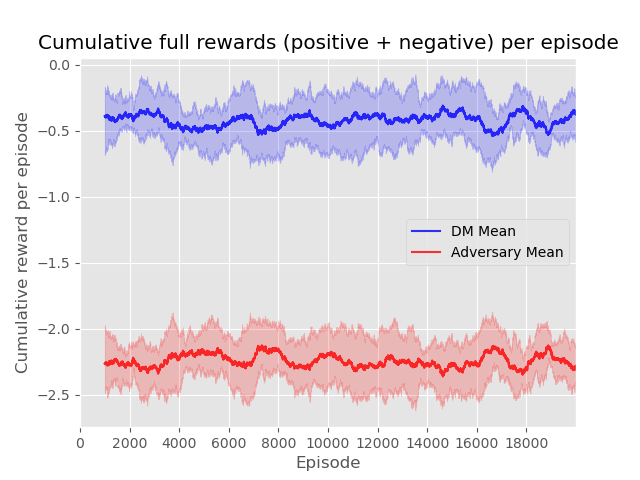

2025-08-21 12:46:38,990 - INFO - 
--- Creating positive reward plot from saved player rewards ---


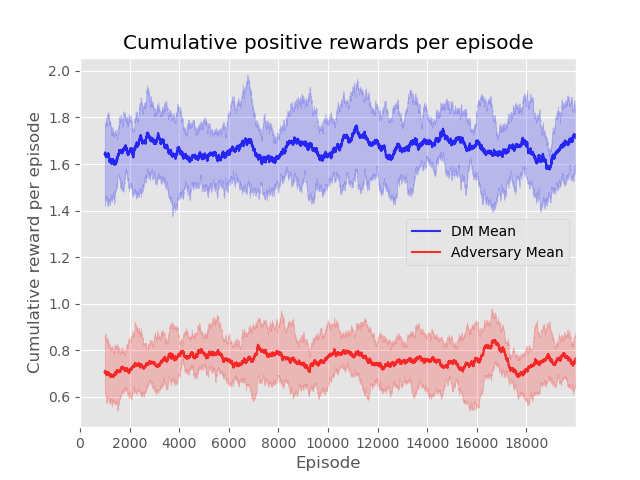

2025-08-21 12:46:39,172 - INFO - 
--- Creating negative reward plot from saved player rewards ---


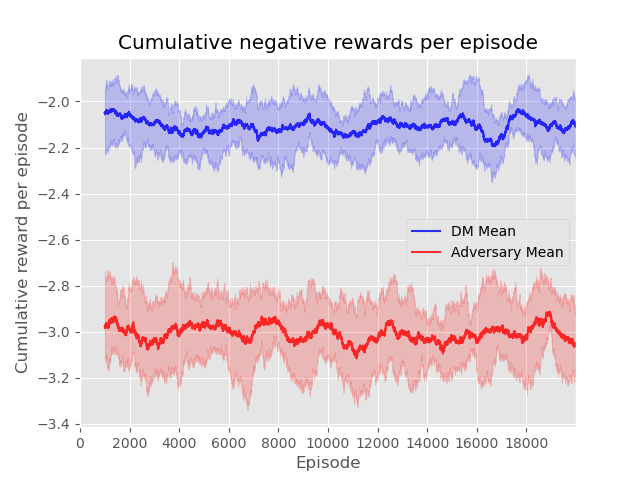

2025-08-21 12:46:39,385 - INFO - 
--- Creating only step reward plot from saved player rewards ---


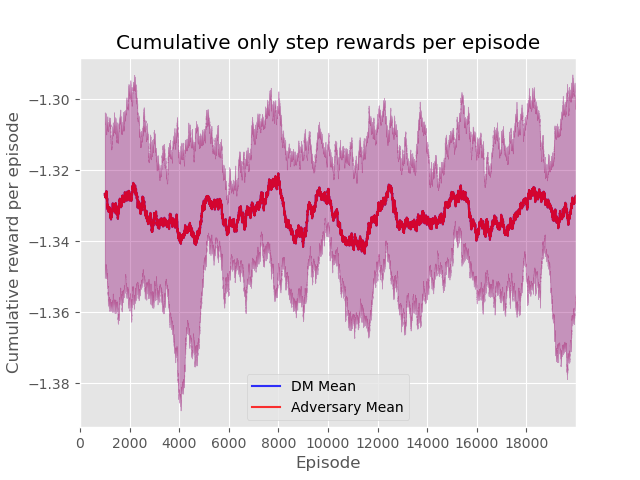

2025-08-21 12:46:39,743 - INFO - 
--- Creating full reward without coin plot from saved player rewards ---


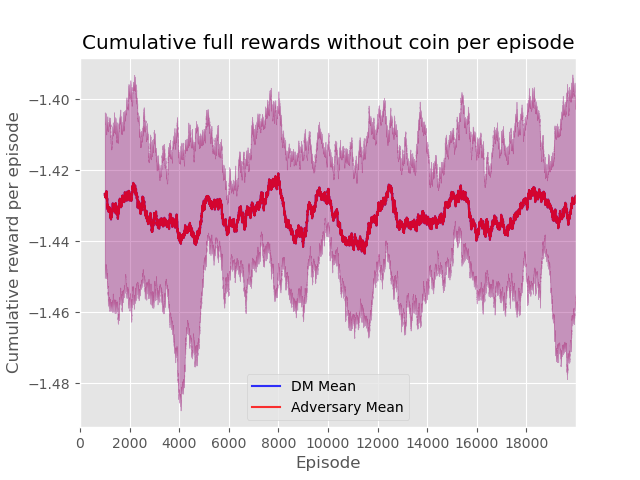

2025-08-21 12:46:40,010 - INFO - 
--- Creating full reward without step plot from saved player rewards ---


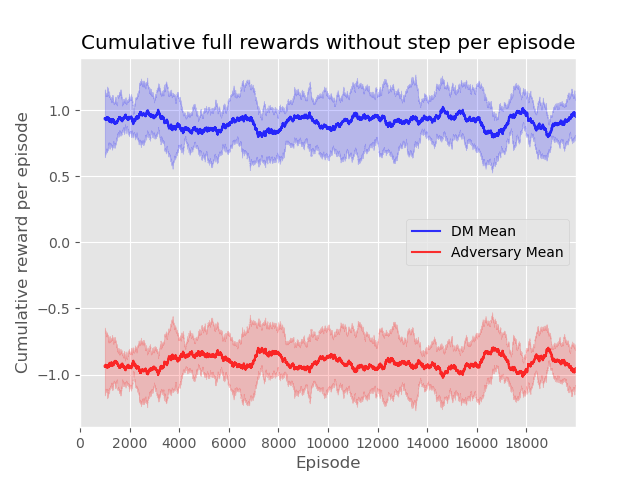

2025-08-21 12:46:40,203 - INFO - 
--- Creating win ratio plot for player 1 ---


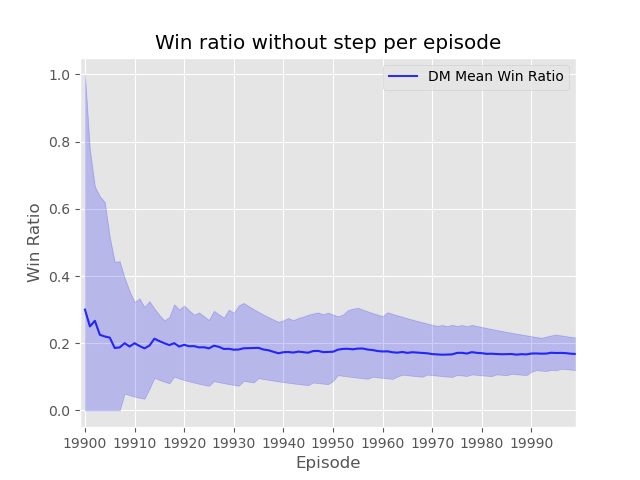

2025-08-21 12:46:40,288 - INFO - 
--- Creating loss ratio plot for player 1 ---


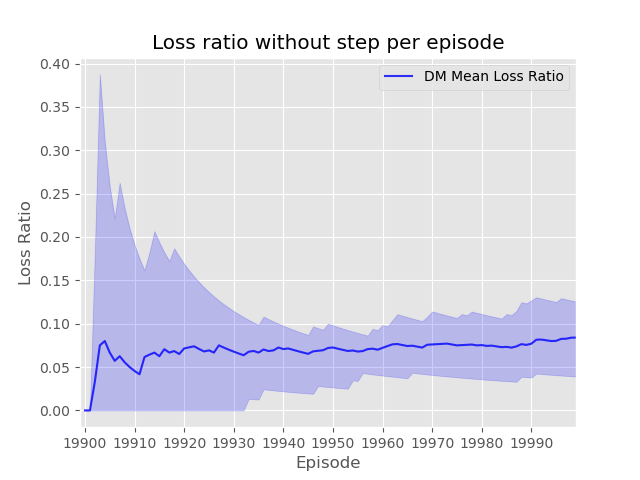

2025-08-21 12:46:40,357 - INFO - 
--- Creating draw ratio plot for player 1 ---


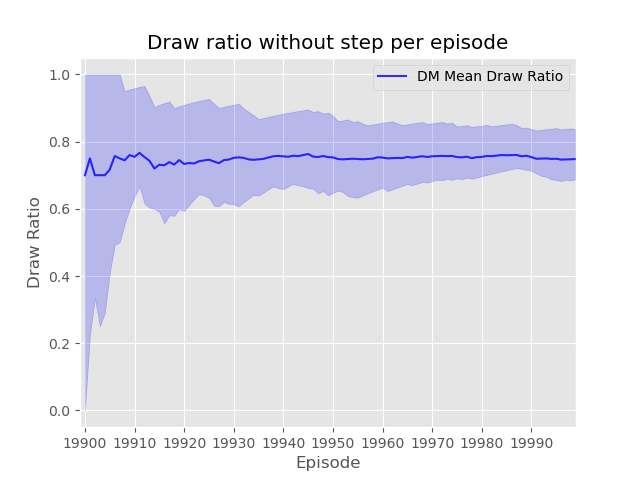

In [5]:
# --- Display the Reward Plot ---
# We can either regenerate the plot from the loaded data or simply display the image that was saved.
# Displaying the image is faster and guarantees we see the original result.

# Plotting full rewards (negative + positive)
if full_rewards_p0 is not None and full_rewards_p1 is not None:
    logging.info("\n--- Creating full reward plot from saved player rewards ---")
    plot_title = 'Cumulative full rewards (positive + negative) per episode'
    
    plot_reward_per_episode_series(full_rewards_p0, full_rewards_p1,
                                   plot_title, episode_series_x_axis_plot_range = reward_time_series_x_axis_plot_range,
                                   moving_average_window_size=plot_moving_average_window_size, dir=None, plot_bands=plot_reward_bands)
else:
    logging.info("\nSkipping full rewards plot display as rewards were not not loaded.")

# Plotting only positive rewards
if positive_rewards_p0 is not None and positive_rewards_p1 is not None:
    logging.info("\n--- Creating positive reward plot from saved player rewards ---")
    plot_title = 'Cumulative positive rewards per episode'
    
    plot_reward_per_episode_series(positive_rewards_p0, positive_rewards_p1,
                                   plot_title, episode_series_x_axis_plot_range = reward_time_series_x_axis_plot_range,
                                   moving_average_window_size=plot_moving_average_window_size, dir=None, plot_bands=plot_reward_bands)
else:
    logging.info("\nSkipping positive rewards plot display as rewards were not not loaded.")

# Plotting only negative rewards
if negative_rewards_p0 is not None and negative_rewards_p1 is not None:
    logging.info("\n--- Creating negative reward plot from saved player rewards ---")
    plot_title = 'Cumulative negative rewards per episode'
    
    plot_reward_per_episode_series(negative_rewards_p0, negative_rewards_p1,
                                   plot_title, episode_series_x_axis_plot_range = reward_time_series_x_axis_plot_range,
                                   moving_average_window_size=plot_moving_average_window_size, dir=None, plot_bands=plot_reward_bands)
else:
    logging.info("\nSkipping negative rewards plot display as rewards were not not loaded.")
    
# Plotting only step rewards
if only_step_rewards_p0 is not None and only_step_rewards_p1 is not None:
    logging.info("\n--- Creating only step reward plot from saved player rewards ---")
    plot_title = 'Cumulative only step rewards per episode'
    
    plot_reward_per_episode_series(only_step_rewards_p0, only_step_rewards_p1,
                                   plot_title, episode_series_x_axis_plot_range = reward_time_series_x_axis_plot_range,
                                   moving_average_window_size=plot_moving_average_window_size, dir=None, plot_bands=plot_reward_bands)
else:
    logging.info("\nSkipping only step rewards plot display as rewards were not not loaded.")
    
# Plotting full rewards without coin
if full_rewards_without_coin_p0 is not None and full_rewards_without_coin_p1 is not None:
    logging.info("\n--- Creating full reward without coin plot from saved player rewards ---")
    plot_title = 'Cumulative full rewards without coin per episode'
    
    plot_reward_per_episode_series(full_rewards_without_coin_p0, full_rewards_without_coin_p1,
                                   plot_title, episode_series_x_axis_plot_range = reward_time_series_x_axis_plot_range,
                                   moving_average_window_size=plot_moving_average_window_size, dir=None , plot_bands=plot_reward_bands)
else:
    logging.info("\nSkipping full rewards without coin plot display as rewards were not not loaded.")
    
# Plotting full rewards without step
if full_rewards_without_step_p0 is not None and full_rewards_without_step_p1 is not None:
    logging.info("\n--- Creating full reward without step plot from saved player rewards ---")
    plot_title = 'Cumulative full rewards without step per episode'
    
    plot_reward_per_episode_series(full_rewards_without_step_p0, full_rewards_without_step_p1,
                                   plot_title, episode_series_x_axis_plot_range = reward_time_series_x_axis_plot_range,
                                   moving_average_window_size=plot_moving_average_window_size, dir=None, plot_bands=plot_reward_bands)
else:
    logging.info("\nSkipping full rewards without step plot display as rewards were not not loaded.")
    
    
# Plotting win ratio for player 1 without step
if game_result_p0 is not None:
    logging.info("\n--- Creating win ratio plot for player 1 ---")
    plot_title = 'Win ratio without step per episode'
    
    plot_result_ration(game_result_p0, episode_range_to_eval, plot_title, result_type_to_plot="win",
        episode_series_x_axis_plot_range=game_result_ratio_x_axis_plot_range, 
        dir=None, plot_bands=plot_result_ratio_bands)
else:
    logging.info("\nSkipping Win ratio plot display as game results were not not loaded.")
    
# Plotting loss ratio for player 1 without step
if game_result_p0 is not None:
    logging.info("\n--- Creating loss ratio plot for player 1 ---")
    plot_title = 'Loss ratio without step per episode'
    
    plot_result_ration(game_result_p0, episode_range_to_eval, plot_title, result_type_to_plot="loss",
        episode_series_x_axis_plot_range=game_result_ratio_x_axis_plot_range, 
        dir=None, plot_bands=plot_result_ratio_bands)
else:
    logging.info("\nSkipping Loss ratio plot display as game results were not not loaded.")
    
# Plotting draw ratio for player 1 without step
if game_result_p0 is not None:
    logging.info("\n--- Creating draw ratio plot for player 1 ---")
    plot_title = 'Draw ratio without step per episode'
    
    plot_result_ration(game_result_p0, episode_range_to_eval, plot_title, result_type_to_plot="draw",
        episode_series_x_axis_plot_range=game_result_ratio_x_axis_plot_range, 
        dir=None, plot_bands=plot_result_ratio_bands)
else:
    logging.info("\nSkipping draw ratio plot display as game results were not not loaded.")

In [6]:
# --- Animate a Specific Episode from the Trajectory Log ---
if trajectory_logs_all_experiments is not None and config is not None:
    logging.info("\n--- Generating Animation from Trajectory Log ---")
    
    try:
        # Select the data for the desired run and episode
        num_runs = int(np.max(trajectory_logs_all_experiments['experiment_num'])) + 1
        num_episodes = int(np.max(trajectory_logs_all_experiments['episode_num'])) + 1
        
        target_run = run_to_animate if run_to_animate >= 0 else num_runs + run_to_animate
        target_episode = episode_to_animate if episode_to_animate >= 0 else num_episodes + episode_to_animate

        # Select desired run and episode to animate using boolean masking
        run_mask = trajectory_logs_all_experiments['experiment_num'] == target_run
        episode_mask = trajectory_logs_all_experiments['episode_num'] == target_episode
        
        episode_data_slice = trajectory_logs_all_experiments[run_mask & episode_mask]
        
        # Sort by step number to ensure correct animation order
        episode_data_slice = episode_data_slice[episode_data_slice['step_num'].argsort()]
        
        if episode_data_slice.shape[0] == 0:
             raise IndexError(f"No data found for run {target_run}, episode {target_episode}. Check your indices.")
        
        grid_size = config['environment_settings']['params']['grid_size']
        
        # Call the animation function
        animate_trajectory_from_log(
            trajectory_episode_array=episode_data_slice,
            grid_size=grid_size, 
            fps=2
        )
        logging.info("Animation saved as 'trajectory.mp4'")
        
        display(Video(url="trajectory.mp4?cache=" + str(time.time()), embed=False))
        
    except (IndexError, TypeError) as e:
        logging.error(f"Could not extract the specified trajectory log. Error: {e}")

else:
    logging.info("\\nSkipping animation as trajectory data or config was not loaded.")

2025-08-21 12:46:43,976 - INFO - 
--- Generating Animation from Trajectory Log ---
2025-08-21 12:46:44,121 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-08-21 12:46:44,122 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x600 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y trajectory.mp4
2025-08-21 12:46:44,853 - INFO - Animation saved as 'trajectory.mp4'
